In [3]:
# This is the shared notebook for our project. It contains the code for the data preprocessing, the model training and the model evaluation.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor


In [4]:
# Load the claims data
data = pd.read_csv('claims_data.csv')

# View the first few rows of the dataset
data.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [5]:
# Check the data types of each column
data.info()

# Check for missing values
data.isnull().sum()

# Summary statistics for numerical columns
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


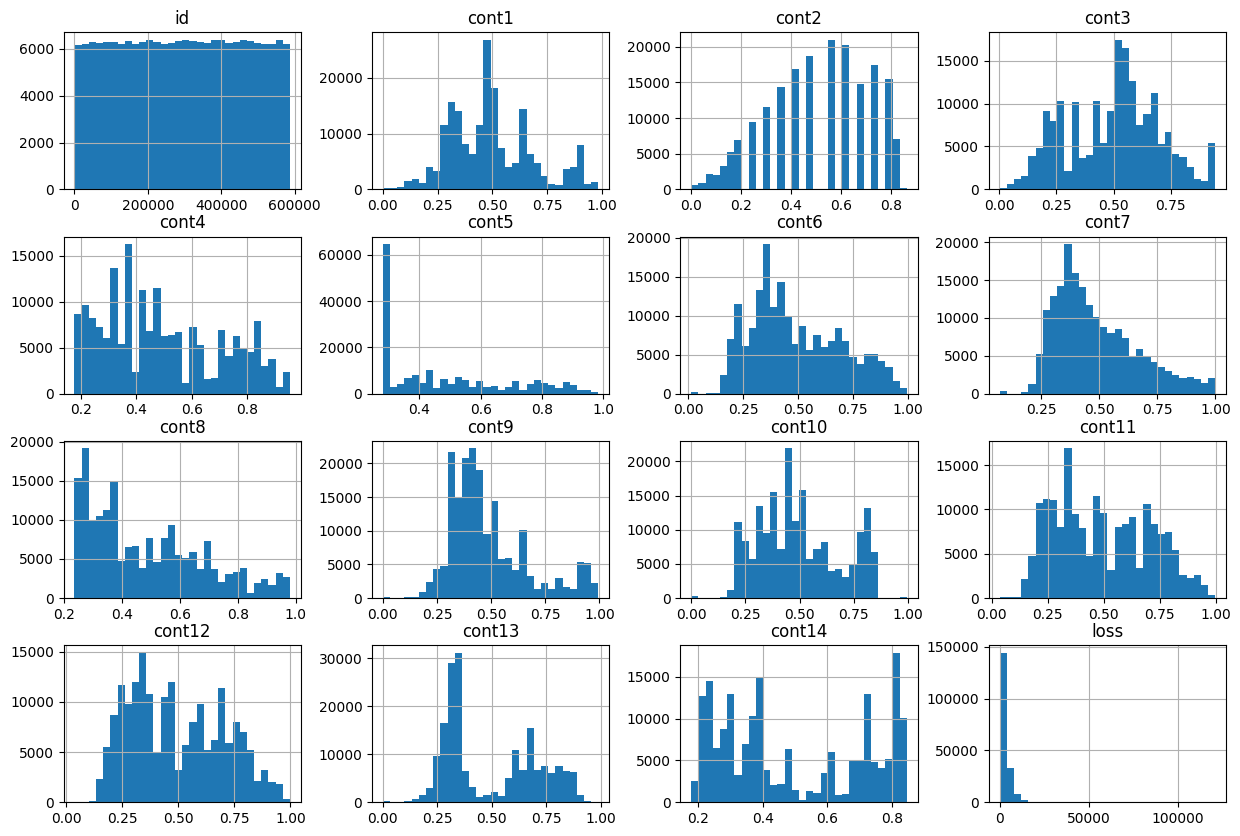

In [6]:
# Visuualizing Data: Understand the distribution of the data
# Plot histograms for numerical columns
data.hist(bins=30, figsize=(15, 10))
plt.show()

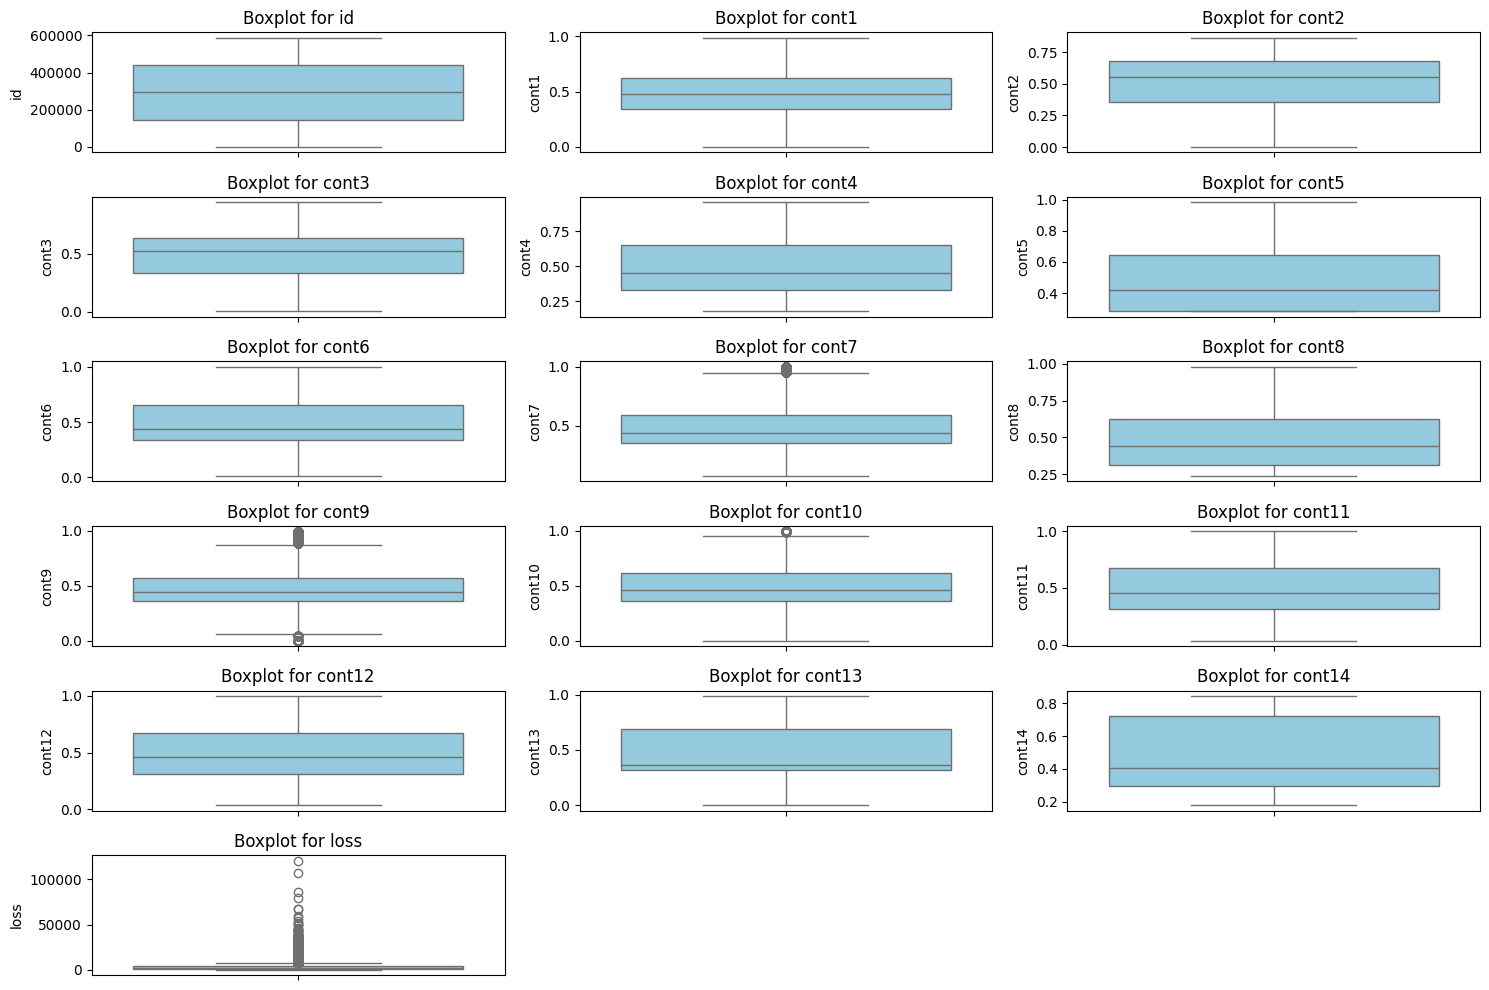

In [7]:
numerical_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize = (15, 10))
for i, col in enumerate(numerical_cols, start=1):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i)  # Arrange in rows of 3
    sns.boxplot(data[col], color='skyblue')
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()

plt.show()

count    188318.000000
mean          0.485506
std           0.181660
min           0.000080
25%           0.358970
50%           0.441450
75%           0.566820
max           0.995400
Name: cont9, dtype: float64


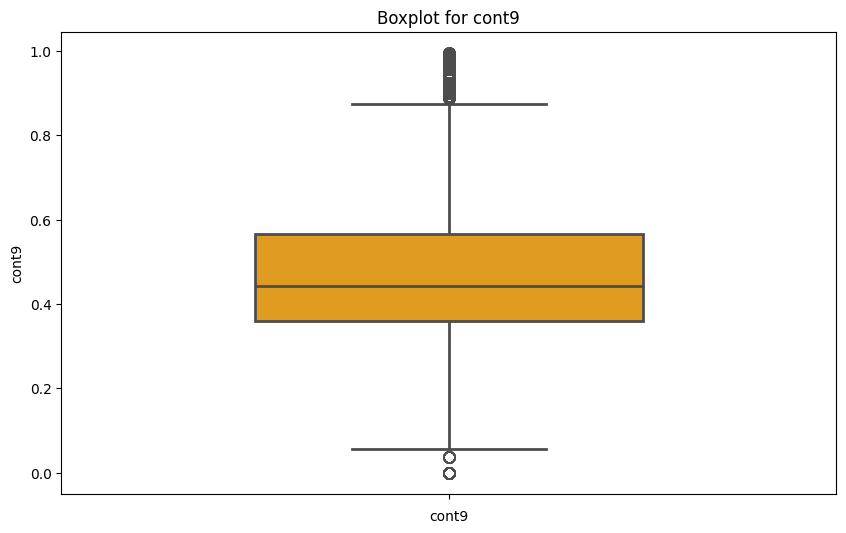

In [10]:
# looking into cont 9 since it seems to have the most outliers
# Summary statistics for cont9
print(data['cont9'].describe())

# Enhanced boxplot for cont9
plt.figure(figsize=(10, 6))
sns.boxplot(data['cont9'], color='orange', width=0.5, fliersize=8, linewidth=2)
plt.title('Boxplot for cont9')
plt.xlabel('cont9')
plt.show()


In [11]:
# Determine which categorical values cannot be converted to boolean data
categorical = [x for x in data.columns if set(pd.unique(data[x])) != {'A', 'B'} and 'cat' in x]
categorical

['cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101',
 'cat102',
 'cat103',
 'cat104',
 'cat105',
 'cat106',
 'cat107',
 'cat108',
 'cat109',
 'cat110',
 'cat111',
 'cat112',
 'cat113',
 'cat114',
 'cat115',
 'cat116']

In [12]:
# One-hot encoding function 
def process_cat(data, cat_features):
    for cat in cat_features:
        # One-hot encode the categorical feature
        data_cat = pd.get_dummies(data[cat], prefix=cat)
        
        # Join the new one-hot encoded columns with the original data
        data = data.join(data_cat)
        
        # Drop the original categorical columns
        data.drop(columns=cat, inplace=True)
    
    return data

data = process_cat(data, categorical)

In [13]:
# Convert other categorical data into boolean data
for i in range(1, 73):
    data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})

data

/var/folders/59/jsc_396x0v35d0gx_bc8_rzm0000gn/T/ipykernel_968/452813681.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,5,True,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,11,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
188314,587624,True,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
188315,587630,True,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
188316,587632,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# removing outlier function
numerical_cats = data.select_dtypes(include=['int64', 'float64'])
def remove_outliers(data, numerical_cats):
    for feature in numerical_cats:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1

        # find lower and upper boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return data

In [15]:
# remove outliers
features_to_clean = ['cont7', 'cont9', 'cont10']

# Apply outlier removal
data_cleaned = remove_outliers(data, features_to_clean)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171158 entries, 0 to 188316
Columns: 1083 entries, id to cat116_Y
dtypes: bool(1067), float64(15), int64(1)
memory usage: 196.4 MB


Mean Square Error: 3098275.0505432463


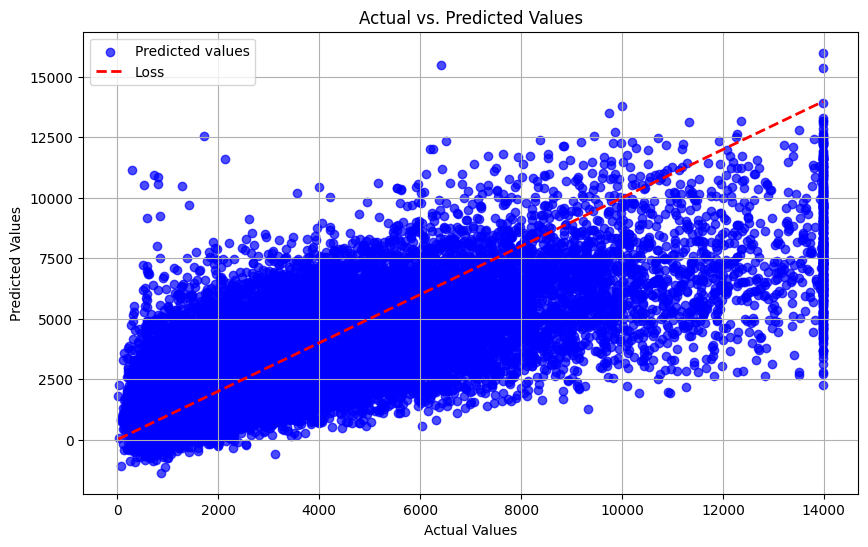

In [16]:
X = data.drop(['loss', 'id'], axis=1)  # Features
y = data['loss']  # Target

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].apply(lambda x: np.minimum(x, np.percentile(x, 99)))
y = np.minimum(y, np.percentile(y, 99))

# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




pipeline = Pipeline([
    ('scalar', RobustScaler()),
    ('sgd', SGDRegressor(
        max_iter=2000, 
        tol=1e-2, 
        random_state=42,
        early_stopping = True,
        validation_fraction = 0.1,
        alpha = 0.0001,
        penalty = 'l2'
        ))
])
# default tol/stopping criteria is 1e-3
#sgd_model = SGDRegressor(max_iter=1000, tol = 1e-3, random_state=42)
# Train the model
pipeline.fit(X_train, y_train)
# Predict
y_pred = pipeline.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Square Error: {mse}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Loss')  # Diagonal line
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()